# Readmission Risk Model — Random Forest

This notebook trains and evaluates a **random forest** model to predict hospital readmission using the synthetic dataset in `../data/hospital_data.csv`.

It complements the logistic regression notebook and focuses on capturing non-linear relationships and providing feature importance for interpretability.

In [3]:
from __future__ import annotations

import os
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


In [4]:
DATA_PATH = "../data/hospital_data.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,Patient_ID,Age,Gender,Diagnosis,Treatment,Length_of_Stay,Outcome,Readmission
0,P0001,45,F,Heart Failure,Medication,5,Recovered,No
1,P0002,60,M,Pneumonia,Antibiotics,7,Recovered,No
2,P0003,30,F,Diabetes,Insulin,3,Recovered,Yes
3,P0004,77,M,Stroke,Surgery,10,Recovered,No
4,P0005,50,F,Diabetes,Insulin,4,Recovered,Yes


In [5]:
def split_features_target(
    data: pd.DataFrame, target_col: str = "Readmission"
) -> Tuple[pd.DataFrame, pd.Series]:
    """Split a DataFrame into features and target.

    Args:
        data: Full input DataFrame containing features and target.
        target_col: Name of the target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]:
        A tuple of (X, y) where X contains all feature columns and y is the target.
    """
    if target_col not in data.columns:
        raise KeyError(f"Target column '{target_col}' not found in DataFrame.")

    X = data.drop(columns=[target_col])
    y = data[target_col]
    return X, y

X, y = split_features_target(df, target_col="Readmission")
X.head()

,Patient_ID,Age,Gender,Diagnosis,Treatment,Length_of_Stay,Outcome
0,P0001,45,F,Heart Failure,Medication,5,Recovered
1,P0002,60,M,Pneumonia,Antibiotics,7,Recovered
2,P0003,30,F,Diabetes,Insulin,3,Recovered
3,P0004,77,M,Stroke,Surgery,10,Recovered
4,P0005,50,F,Diabetes,Insulin,4,Recovered


In [6]:
# Identify column types
categorical_cols: List[str] = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols: List[str] = X.select_dtypes(include=["number"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Column transformer for preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape

Categorical columns: ['Patient_ID', 'Gender', 'Diagnosis', 'Treatment', 'Outcome']
Numeric columns: ['Age', 'Length_of_Stay']


((16, 7), (4, 7))

In [7]:
rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "clf",
            RandomForestClassifier(
                n_estimators=200,
                random_state=42,
                n_jobs=-1,
            ),
        ),
    ]
)

rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Patient_ID', 'Gender',
                                                   'Diagnosis', 'Treatment',
                                                   'Outcome']),
                                                 ('num', 'passthrough',
                                                  ['Age', 'Length_of_Stay'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [8]:
from sklearn.metrics import f1_score

def evaluate_with_threshold(
    model: Pipeline,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    threshold: float = 0.5,
) -> Dict[str, float]:
    """Evaluate a classifier at a custom decision threshold."""
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred_custom = (y_proba >= threshold).astype(int)

    # Map "Yes"/"No" to 1/0 if needed
    y_val_bin = (y_val == "Yes").astype(int)

    acc = accuracy_score(y_val_bin, y_pred_custom)
    prec = precision_score(y_val_bin, y_pred_custom, zero_division=0)
    rec = recall_score(y_val_bin, y_pred_custom, zero_division=0)
    f1 = f1_score(y_val_bin, y_pred_custom, zero_division=0)

    print(f"Threshold={threshold:.2f} | acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

for t in [0.5, 0.4, 0.3, 0.25, 0.2]:
    evaluate_with_threshold(rf_model, X_test, y_test, threshold=t)

Threshold=0.50 | acc=0.500, prec=0.000, rec=0.000, f1=0.000
Threshold=0.40 | acc=1.000, prec=1.000, rec=1.000, f1=1.000
Threshold=0.30 | acc=1.000, prec=1.000, rec=1.000, f1=1.000
Threshold=0.25 | acc=1.000, prec=1.000, rec=1.000, f1=1.000
Threshold=0.20 | acc=1.000, prec=1.000, rec=1.000, f1=1.000


In [9]:
def evaluate_classifier(
    name: str,
    model: Pipeline,
    X_test: pd.DataFrame,
    y_test: pd.Series,
) -> Dict[str, float]:
    """Evaluate a classifier on test data and print key metrics.

    Args:
        name: Human-readable model name.
        model: Fitted sklearn Pipeline.
        X_test: Test features.
        y_test: Ground-truth labels.

    Returns:
        Dict[str, float]: accuracy, precision, recall, F1, ROC-AUC.
    """
    y_pred = model.predict(X_test)

    # Try probability for ROC-AUC
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except Exception:
        roc_auc = float("nan")

    # Explicitly set the positive label
    pos = sorted(y_test.unique())[-1]   # positive = lexicographically last

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=pos)
    rec = recall_score(y_test, y_pred, pos_label=pos)
    f1 = f1_score(y_test, y_pred, pos_label=pos)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
    }

    print(f"{name} performance:")
    for k, v in metrics.items():
        print(f"  {k:9s}: {v:.3f}")

    return metrics


rf_metrics = evaluate_classifier("Random Forest", rf_model, X_test, y_test)
rf_metrics

Random Forest performance:
  accuracy : 0.500
  precision: 0.000
  recall   : 0.000
  f1       : 0.000
  roc_auc  : 1.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc_auc': 1.0}

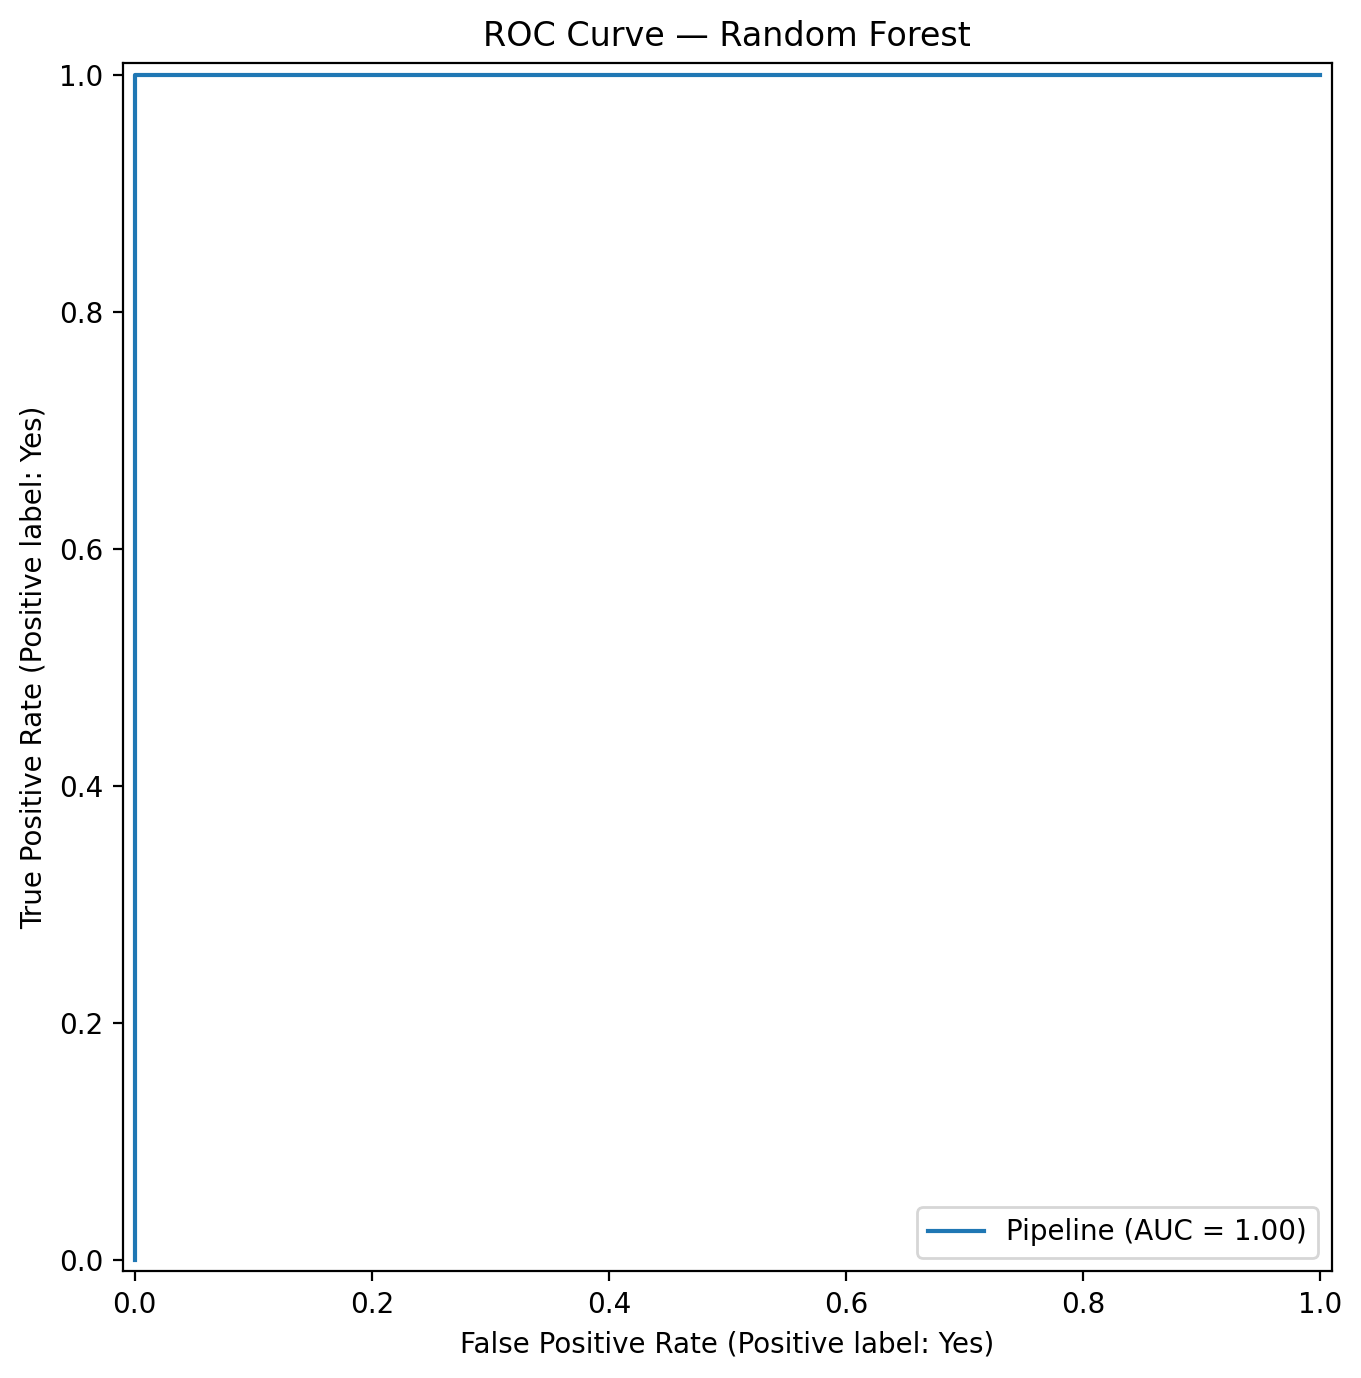

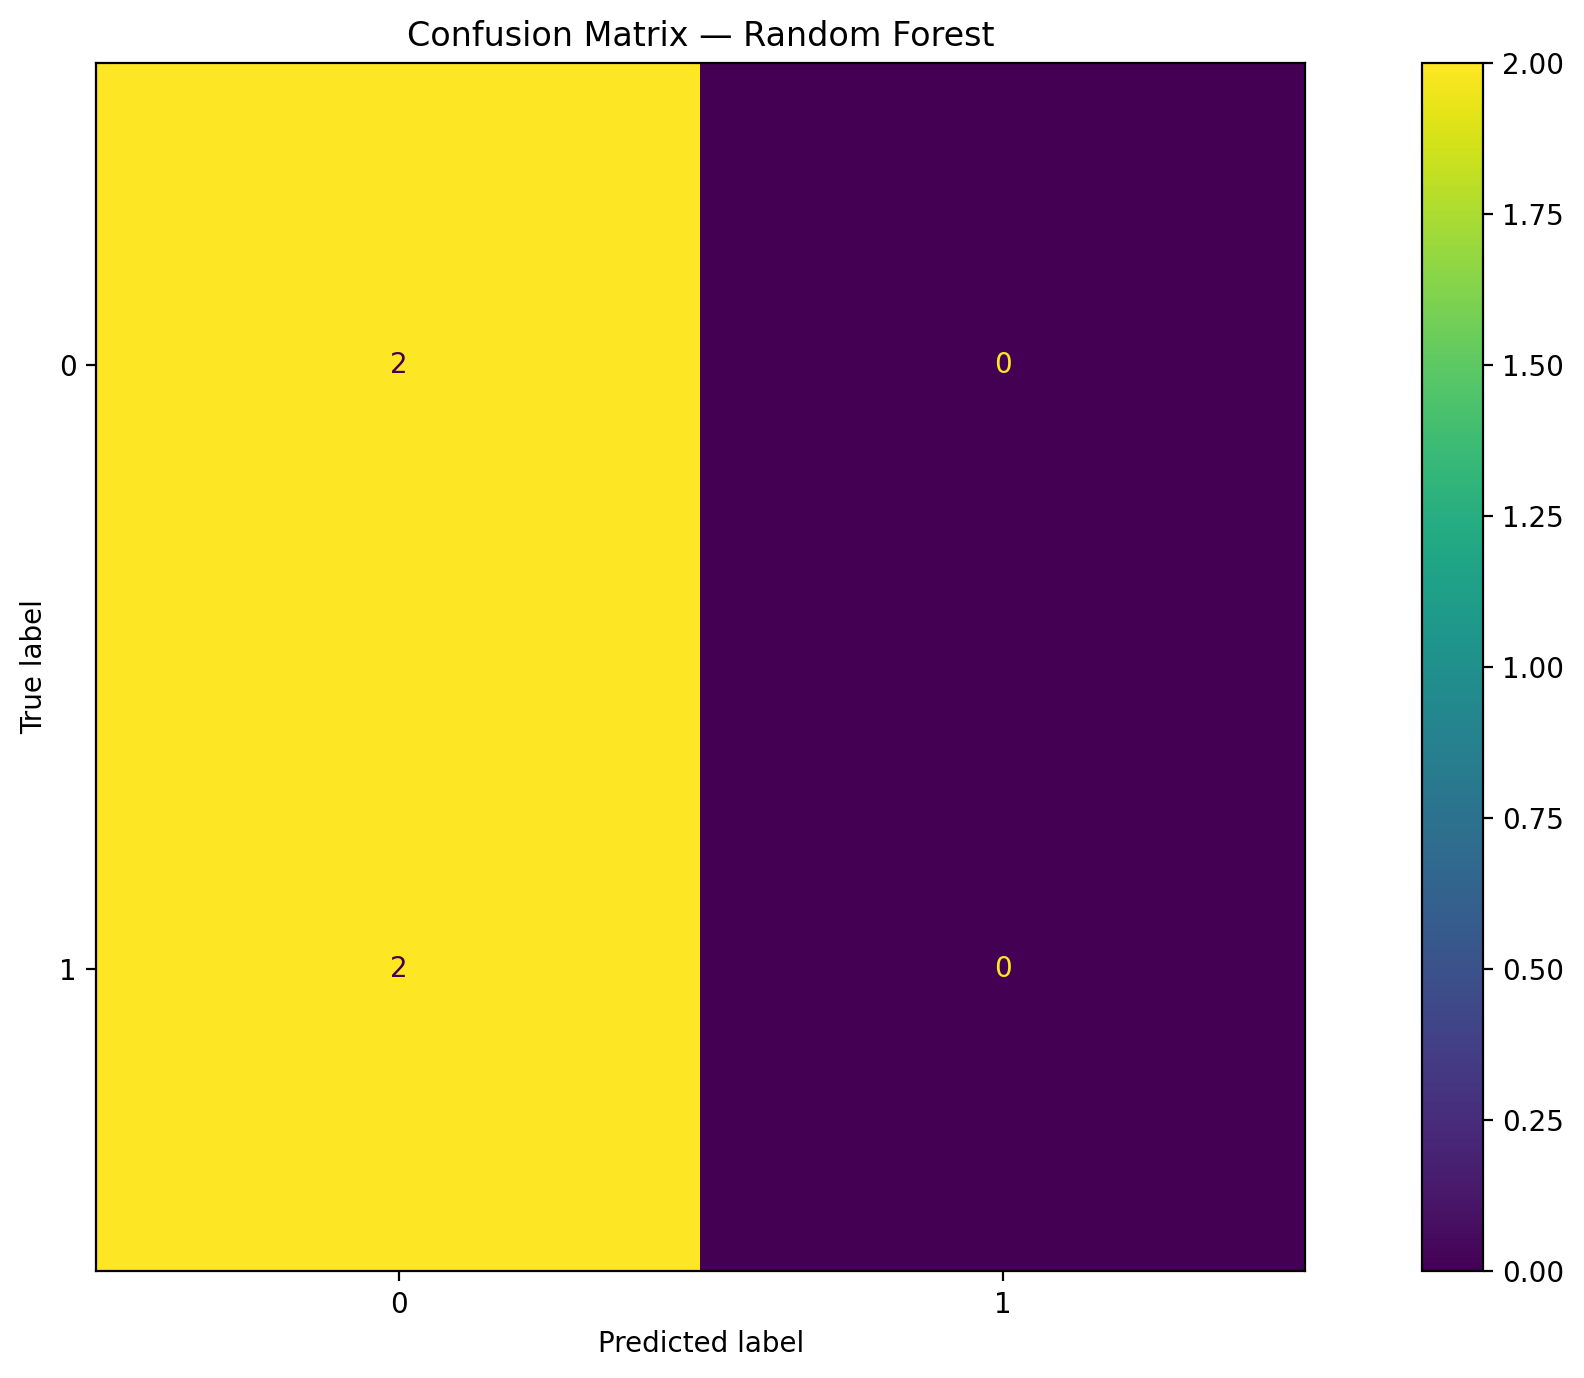

In [10]:
# ROC curve
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve — Random Forest")
plt.tight_tight = plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, rf_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()

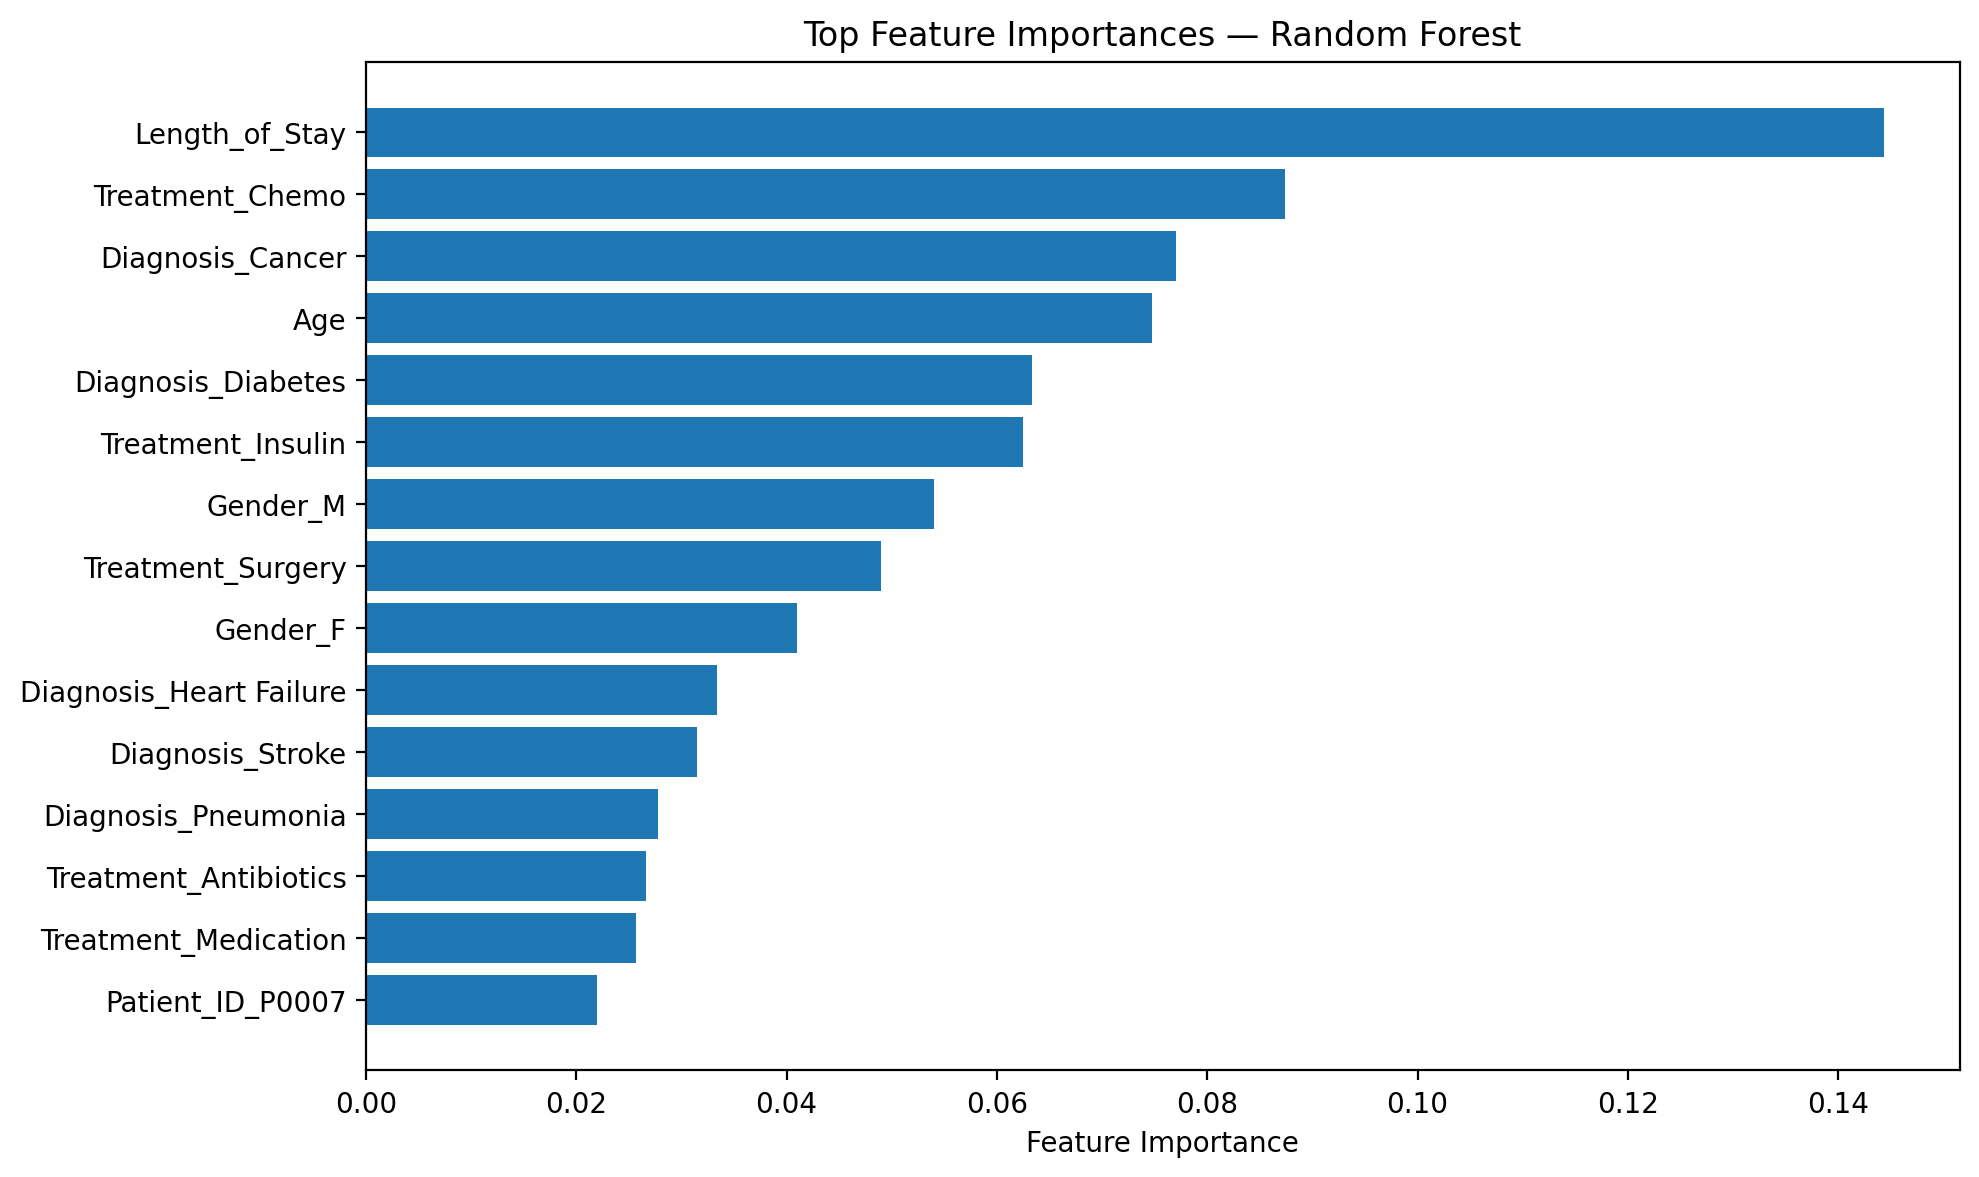

In [11]:
# Feature importance plot
os.makedirs("assets", exist_ok=True)

# Refit preprocess on training data to access feature names
preprocess.fit(X_train)

ohe = preprocess.named_transformers_["cat"]
encoded_cat_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(encoded_cat_names) + numeric_cols

rf_clf = rf_model.named_steps["clf"]
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 15
top_features = [all_feature_names[i] for i in indices[:top_n]]
top_importances = importances[indices[:top_n]]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances[::-1])
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances — Random Forest")
plt.tight_layout()
plt.savefig("assets/feature_importance.png", dpi=150)
plt.show()